In [2]:
import pandas as pd
import numpy as np
from scipy.linalg import svd, qr
import os
# import geopandas as gpd
# from shapely import wkt
import matplotlib.pyplot as plt
import glob
import random
random.seed(6532)

In [3]:
agg_traffic_pattern = r"aggregated/*_aggregated.csv"


## Loading data

In [4]:
def load_files(list_files):
	agg_traffic_list = []
	for file_name in list_files:
		agg_traffic = pd.read_csv(file_name, engine='pyarrow', delimiter=";")
		agg_traffic = agg_traffic[['interval_begin', 'edge_id', 'edge_entered','edge_departed']]
		agg_traffic["edge_count"] = agg_traffic["edge_entered"] + agg_traffic["edge_departed"]
		agg_traffic.drop(columns=['edge_departed', 'edge_entered'], inplace=True)
		agg_traffic["date"] = file_name.split("/")[-1].split("_")[0]
		
		agg_traffic_list.append(agg_traffic)
	return agg_traffic_list

In [5]:
## Load files
list_files = glob.glob(agg_traffic_pattern)
random.shuffle(list_files)



nb_days_for_validation = 1
list_files_train = list_files[nb_days_for_validation:]
print("list train:", list_files_train)
list_files_val = list_files[:nb_days_for_validation]
print("list val:", list_files_val)

agg_traffic_train_list = load_files(list_files_train)
agg_traffic_val_list = load_files(list_files_val)

list train: ['aggregated/2023-06-10_aggregated.csv', 'aggregated/2023-06-05_aggregated.csv', 'aggregated/2023-06-06_aggregated.csv', 'aggregated/2023-06-09_aggregated.csv', 'aggregated/2023-06-01_aggregated.csv', 'aggregated/2023-06-07_aggregated.csv', 'aggregated/2023-06-11_aggregated.csv', 'aggregated/2022-09-06_aggregated.csv']
list val: ['aggregated/2023-06-13_aggregated.csv']


In [6]:
for i, agg_traffic in enumerate(agg_traffic_train_list):
	agg_traffic['interval_begin'] = agg_traffic['interval_begin']

agg_traffic_train = pd.concat(agg_traffic_train_list)
agg_traffic_train


,interval_begin,edge_id,edge_count,date
0,0.0,-1001559563#1,0,2023-06-10
1,0.0,-1001559570#1,0,2023-06-10
2,0.0,-1001559570#5,0,2023-06-10
3,0.0,-1001559571#1,0,2023-06-10
4,0.0,-1001559572#0,0,2023-06-10
...,...,...,...,...
162235,82800.0,998323895,67,2022-09-06
162236,82800.0,998333666#1,52,2022-09-06
162237,82800.0,998333667,91,2022-09-06
162238,82800.0,998333670,0,2022-09-06


In [7]:
agg_traffic_train.describe()

,interval_begin,edge_count
count,1.297920e+06,1.297920e+06
mean,4.140000e+04,2.958096e+01
std,2.491988e+04,6.657012e+01
min,0.000000e+00,0.000000e+00
25%,2.070000e+04,0.000000e+00
50%,4.140000e+04,3.000000e+00
75%,6.210000e+04,2.500000e+01
max,8.280000e+04,1.410000e+03


In [8]:
agg_traffic_train["edge_id"] = agg_traffic_train["edge_id"].astype('string')
agg_traffic_train["edge_id"]

# agg_traffic_train[agg_traffic_train["edge_id"] == "-1001559572#2"]

0         -1001559563#1
1         -1001559570#1
2         -1001559570#5
3         -1001559571#1
4         -1001559572#0
              ...      
162235        998323895
162236      998333666#1
162237        998333667
162238        998333670
162239        998333676
Name: edge_id, Length: 1297920, dtype: string

In [9]:
merge_hour_and_date = lambda df: pd.to_datetime(df['date']) + pd.to_timedelta(df['interval_begin'], unit='s')

df_traffic = agg_traffic_train.copy(deep=True)
df_traffic['timestamp'] = merge_hour_and_date(df_traffic)
df_traffic.drop(columns=['interval_begin', 'date'], inplace=True)
df_traffic.set_index('timestamp', inplace=True)
df_traffic

df_traffic.columns = ['id', 'count']
len(df_traffic)

1297920

In [10]:
df = df_traffic.groupby("id")["count"].sum().reset_index()
df1 = df[df["count"]!=0]
myedge = set(df1["id"])
df_traffic = df_traffic[df_traffic['id'].apply(lambda x: x in myedge)]
len(df_traffic)


935808

In [11]:
df_traffic

,id,count
timestamp,,
2023-06-10 00:00:00,-1001559571#1,0
2023-06-10 00:00:00,-1001559572#2,0
2023-06-10 00:00:00,-1004129376#10,1
2023-06-10 00:00:00,-1004129377#1,12
2023-06-10 00:00:00,-1004129377#13,10
...,...,...
2022-09-06 23:00:00,998248504#0,129
2022-09-06 23:00:00,998323891#0,58
2022-09-06 23:00:00,998323895,67


## Distribution of the counts

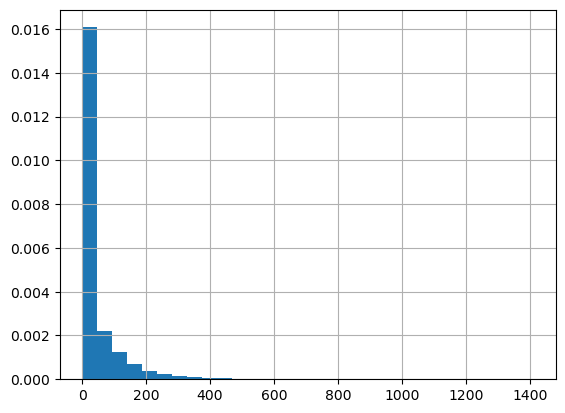

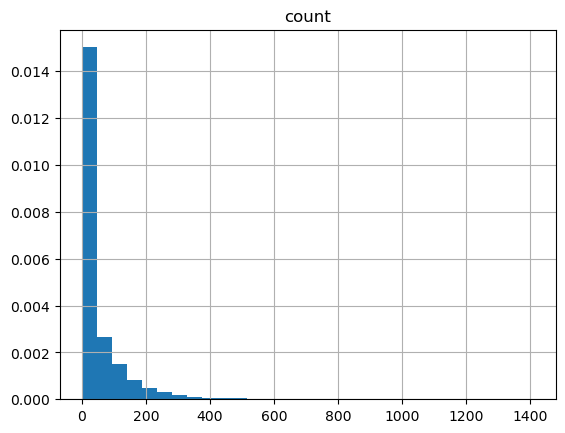

count    935808.00
mean         41.03
std          75.34
min           0.00
25%           2.00
50%          10.00
75%          45.00
max        1410.00
Name: count, dtype: float64

In [12]:
df_traffic['count'].hist(bins=30, density=True)
# plt.yscale('log')
plt.show()

ax = df_traffic.query('count != 0').hist(bins=30, density=True)
ax 
plt.show()

df_traffic['count'].describe().round(2)

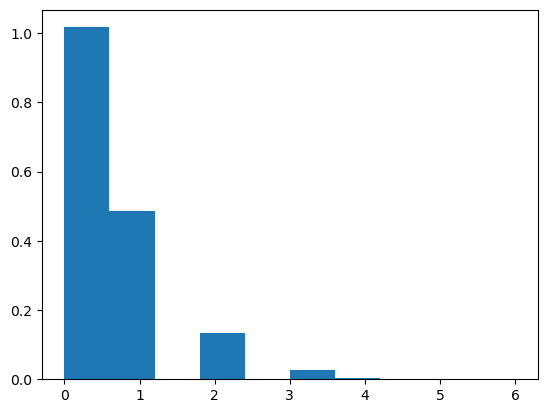

In [13]:
import scipy.stats as stats

# play around with distributions that could possibly be a good fit
# samples = stats.poisson(0.5).rvs(100000) # poisson
samples = stats.nbinom(10, 0.95).rvs(10000) # negative binomial
plt.hist(samples, density=True)
plt.show()



Findings:
- distribution seems highly skewed
- some of the distributions that visually seem to be relevant could be exponential, gamma, poisson, and negative binomial
- based on my simple empirical tests on poisson and negative binomial, I do not think they are the right option
- have to try other possible families such as exponential distribution too

Other Possibilities:
- mixture of poisson, nbinom, etc.
- truncated right skwed normal distribution or a mixutre of them combined with/without a dirac-delta on zero
- completely discrete case (it might have its own challenges but also its own benefits)
- preprocessing the data such that it would less skewed i.e. log-transform or similar approaches

Importance:
- learning this distribution with MSE might prove to be futile as MSE learns the mean of the distribution
- and since the distribution seem to be skwed use of MSE can create instablity in the learning

## Time-series clustering

In [14]:
# number of unique roads 
print(len(df_traffic["id"].unique())) 

# just some check  
(df_traffic["id"].value_counts() == 192).all() # result: each id is repeated 192 times --> 192 hours --> 8 days

4874


True

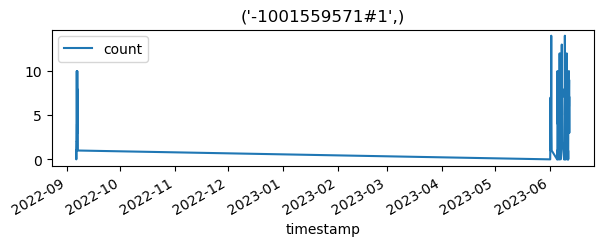

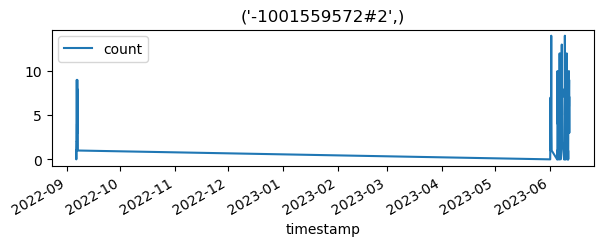

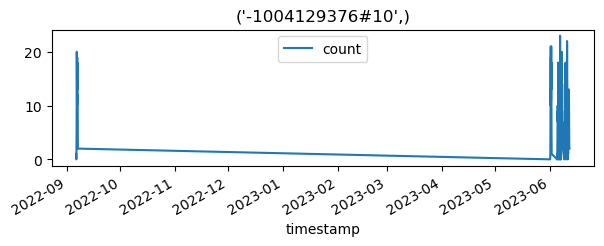

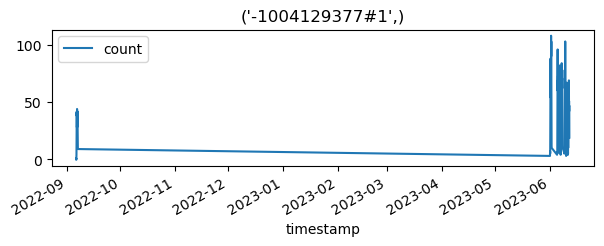

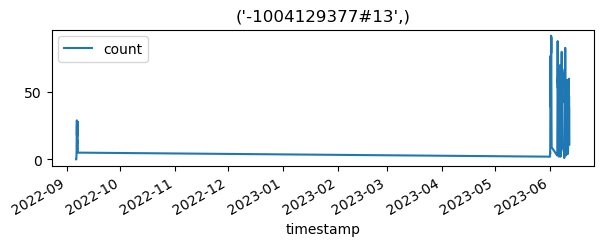

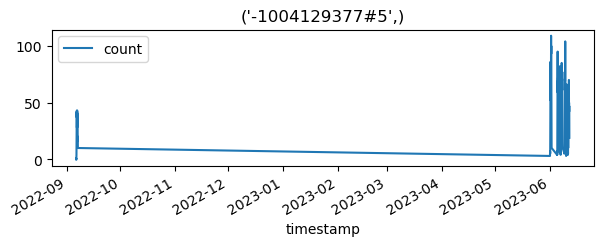

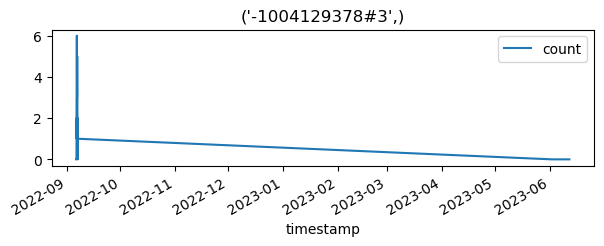

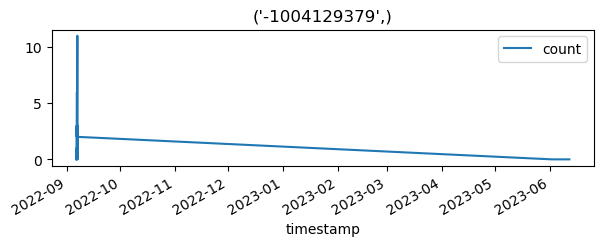

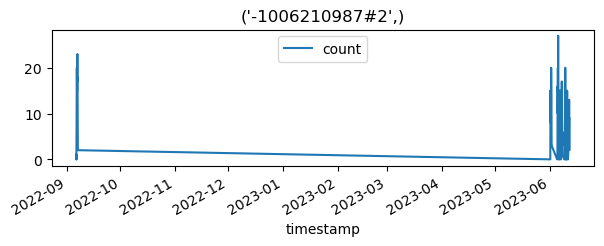

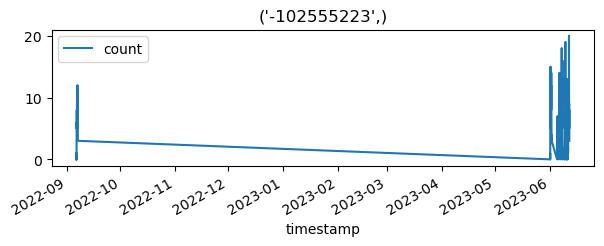

In [15]:
# plot a few of the timeseries
n = 0
for road, df in df_traffic.groupby(["id"]):
    df.plot(title=f'{road}', figsize=(7,2))
    plt.show()
    n+=1
    if n == 10:
        break

In [ ]:
# edges that are constantly zero may be removed but anyway they could be categorized into constantly zero edges
# NB: edges that are ocassionally zero should not be removed as their removal can alter their length

In [16]:
df_traffic.shape

from sklearn.model_selection import train_test_split


train_test_split(df_traffic, )

[                               id  count
 timestamp                               
 2023-06-01 06:00:00      32405512     81
 2023-06-09 13:00:00    -725073808     58
 2023-06-09 21:00:00  -722590012#2      2
 2023-06-01 21:00:00    29981015#0     19
 2023-06-06 14:00:00   733057869#0    196
 ...                           ...    ...
 2023-06-05 13:00:00    29981401#7      8
 2023-06-05 04:00:00    29981159#0      1
 2023-06-11 04:00:00   261675855#0     10
 2023-06-10 03:00:00   -30008518#8     30
 2023-06-06 18:00:00   -30010583#3      3
 
 [701856 rows x 2 columns],
                                id  count
 timestamp                               
 2022-09-06 17:00:00    35341839#0     44
 2023-06-09 06:00:00    29981035#3      0
 2023-06-10 10:00:00   764250221#0      2
 2023-06-10 22:00:00   -29981286#3      2
 2023-06-01 20:00:00   -29980903#3      3
 ...                           ...    ...
 2023-06-11 18:00:00     261675864     81
 2023-06-05 15:00:00   996546539#5     11
 202

In [17]:
ids = []
values = []
timestamps = []
for id, val in df_traffic.groupby('id'):
    ids.append(id)
    values.append(val)
    timestamps.append(val.index) # since all days have same timestamp, all should be the same

values = np.array(values)
ids = np.array(ids)
timestamps = np.array(timestamps)

print(ids.shape)
print(values.shape)
print(timestamps.shape)

(4874,)
(4874, 192, 2)
(4874, 192)


In [97]:
# Perform time series clustering using k-means
# adapted from https://www.geeksforgeeks.org/similarity-search-for-time-series-data/
#
from tslearn.clustering import TimeSeriesKMeans

X = values[:300,:,1] 
n_cluster = 3
km = TimeSeriesKMeans(n_clusters=n_cluster, metric="dtw", n_jobs=-1)
y_pred = km.fit_predict(X[:,:,np.newaxis])

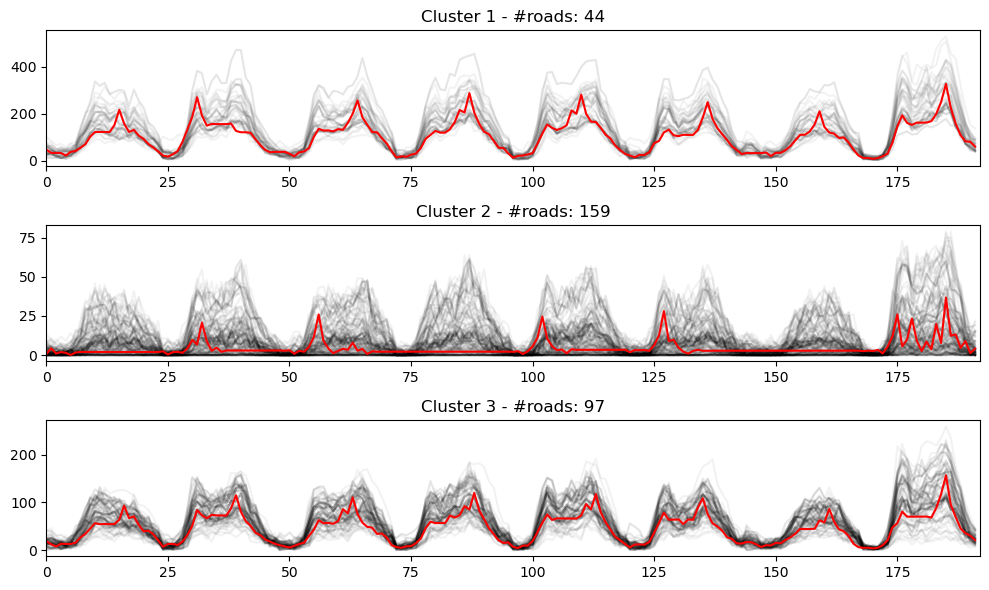

In [98]:
# Plot the clustered time series data
plt.figure(figsize=(10, 2*n_cluster))
for yi in range(n_cluster):
    plt.subplot(n_cluster, 1, 1 + yi)
    for xx in X[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.05)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, X.shape[1])
    # plt.ylim(-4, 4)
    plt.title(f"Cluster {yi + 1} - #roads: {(y_pred==yi).sum()}")
plt.tight_layout()
plt.show()

Since we are solely interested in the historical timeseries data the most simple apporach is to employ methods for timeseries clustering.
Conclusion: visually inspecting, the task seems to be solvable via this approach.

TODOs:
- preprocess the data (normalize/standardize)
- hyperparameter tuning especially for the number of clusters
- establish train and test performance

Some Notes:
- it may not scale well with the amount of data but it is simple and fast to apply at test time
- 

## Forecast for each cluster

A time-series model that can learn from the historical timeseries of each cluster.

TODO:
- first, find clusters such that the n_cluster is no exhibitively large i.e. less than 10 
- second, make sure each cluster contains sufficient number of roads/samples in it i.e. >500
- third, train a separate model for each cluster

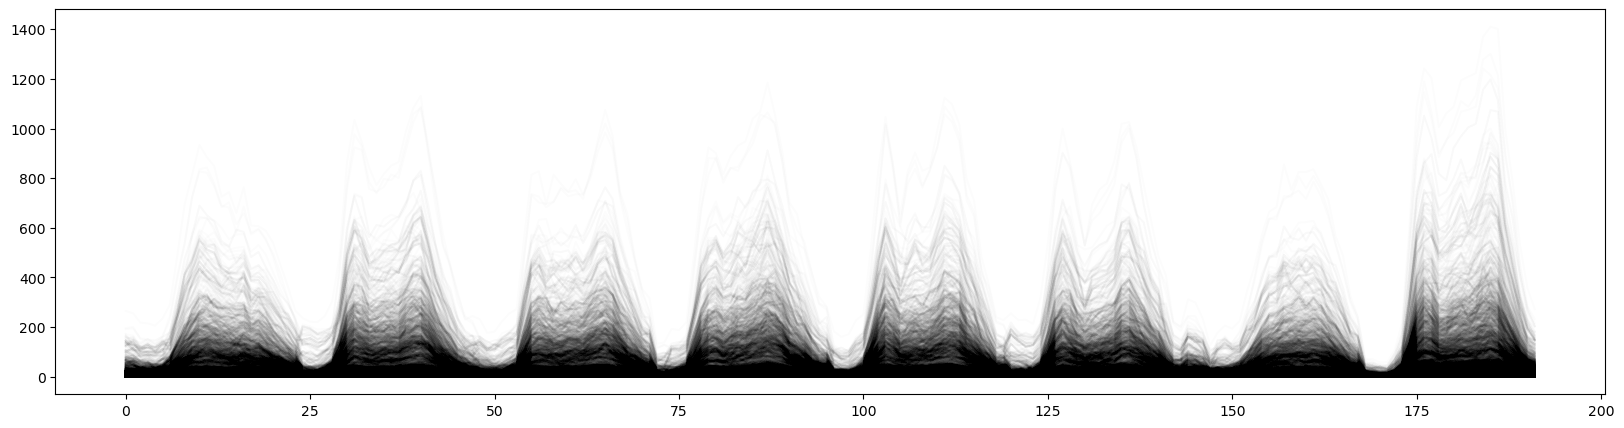

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(values[:,:,1].T, 'k-', alpha=0.01)
plt.show()

In [52]:
# np.unique(pd.to_datetime(timestamps[0]).hour, return_counts=True)
# np.unique(pd.to_datetime(timestamps[0]).day_of_week.nunique(), return_counts=True)

(array([7]), array([1]))

In [82]:
cluster_i=0
data = X[y_pred == cluster_i]
data.shape
df = pd.DataFrame(data.T, index=pd.to_datetime(timestamps[0]))
df['h'] = np.sin(df.index.hour)
df[]
df.head()

,0,1,2,3,4,5,6,7,8,9,...,97,98,99,100,101,102,103,104,105,h
2023-06-10 00:00:00,12,10,12,20,15,15,15,15,15,15,...,1,1,5,5,21,39,9,21,12,0.000000
2023-06-10 01:00:00,14,11,14,14,13,13,13,13,13,13,...,2,2,6,6,19,46,4,19,10,0.841471
2023-06-10 02:00:00,11,10,11,13,11,11,11,11,11,11,...,5,6,5,5,17,31,4,17,11,0.909297
2023-06-10 03:00:00,3,3,3,11,2,2,2,2,2,2,...,8,5,5,5,11,18,3,11,11,0.141120
2023-06-10 04:00:00,9,8,9,13,5,5,5,5,5,5,...,8,9,4,4,9,21,5,9,7,-0.756802
